In [1]:
import pandas as pd
import numpy as np 
from pathlib import Path
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

#fill nan value with the row mean (ie. the mean return of other aseet of that day (row))
def fillna_rowmean(df):
  m  = df.mean(axis=1)
  for i,col in enumerate(df):
    df.iloc[:,i] = df.iloc[:,i].fillna(m)
  return df

# Load Data and Data Preprocessing

In [5]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['date'])
df_ls = []
tickers = df.ticker.unique()
for  ticker in tqdm(tickers):
    aux = df[df.ticker==ticker].set_index('Date')[['last','volume']].dropna()
    aux.columns = [ticker,ticker+'_Vol'] 
    df_ls.append(aux)
df_all = pd.concat(df_ls,axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:04<00:00, 49.74it/s]


In [6]:
df_all.head()

,1332 JT,1332 JT_Vol,1333 JT,1333 JT_Vol,1334 JT,1334 JT_Vol,1605 JT,1605 JT_Vol,1721 JT,1721 JT_Vol,...,9681 JT,9681 JT_Vol,9735 JT,9735 JT_Vol,9766 JT,9766 JT_Vol,9983 JT,9983 JT_Vol,9984 JT,9984 JT_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,169.0987,1464100,NaN,NaN,147.8887,1553000.0,970.6780,5312400,950.5521,816600,...,567.3170,1114500.0,3719.2396,800500,1721.7623,1513200,20584.8363,587300,1482.3931,12023000
2013-01-07,166.3266,1783500,NaN,NaN,144.9890,1419000.0,960.1615,3724400,924.2187,1464400,...,594.1617,2862000.0,3732.0499,688400,1695.8510,1841700,21150.4557,980700,1453.9312,13892400
2013-01-08,166.3266,1759800,NaN,NaN,144.9890,869000.0,955.9548,5019600,938.6596,929800,...,585.2135,1620000.0,3736.3199,760300,1627.9455,2582000,21243.1802,616800,1472.9058,10749800
2013-01-09,165.4026,767800,NaN,NaN,144.9890,654000.0,944.3866,6668800,945.4553,663000,...,631.7442,3021500.0,3757.6703,848200,1612.7561,2015400,21159.7281,633900,1442.0720,11551600
2013-01-10,167.2507,1503100,NaN,NaN,144.9890,661000.0,942.2833,6485200,943.7564,665000,...,619.2167,1099000.0,3791.8310,635100,1568.9749,3119100,20918.6445,588100,1442.0720,8860200


## check the data (outliers?)

We check the outliers of each stock via boxplot of daily returns, we can see from the boxplot below that there exist outliers. For some stocks, the daily returns can go above 0.4 or below -0.2, which is far away from the box. 

<AxesSubplot:>

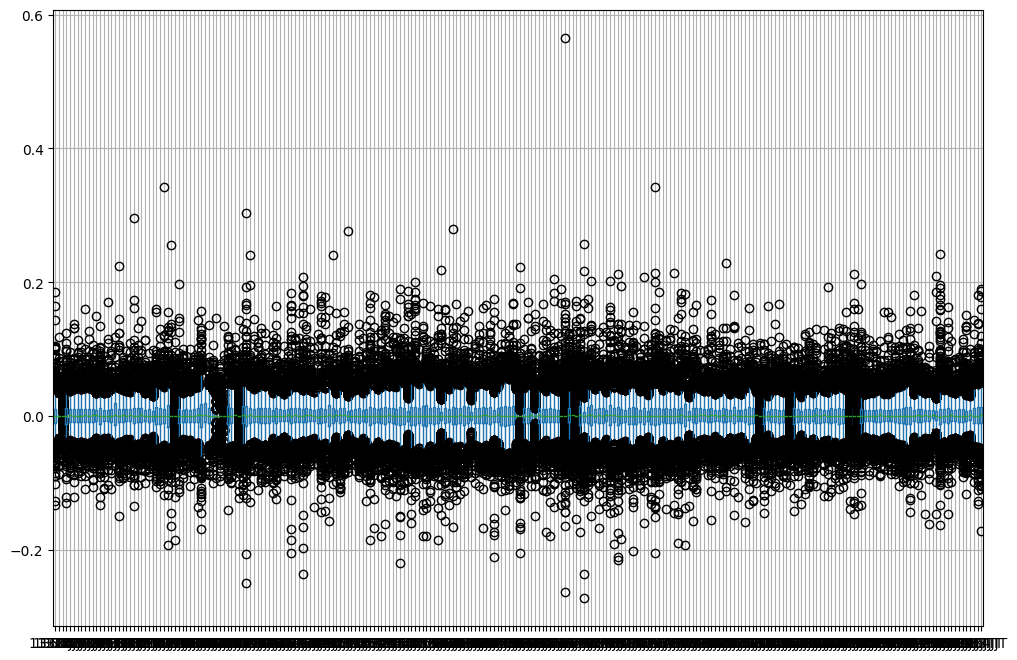

In [7]:
df_all[tickers].pct_change().boxplot(figsize=(12,8))

## Check the correlation matrix

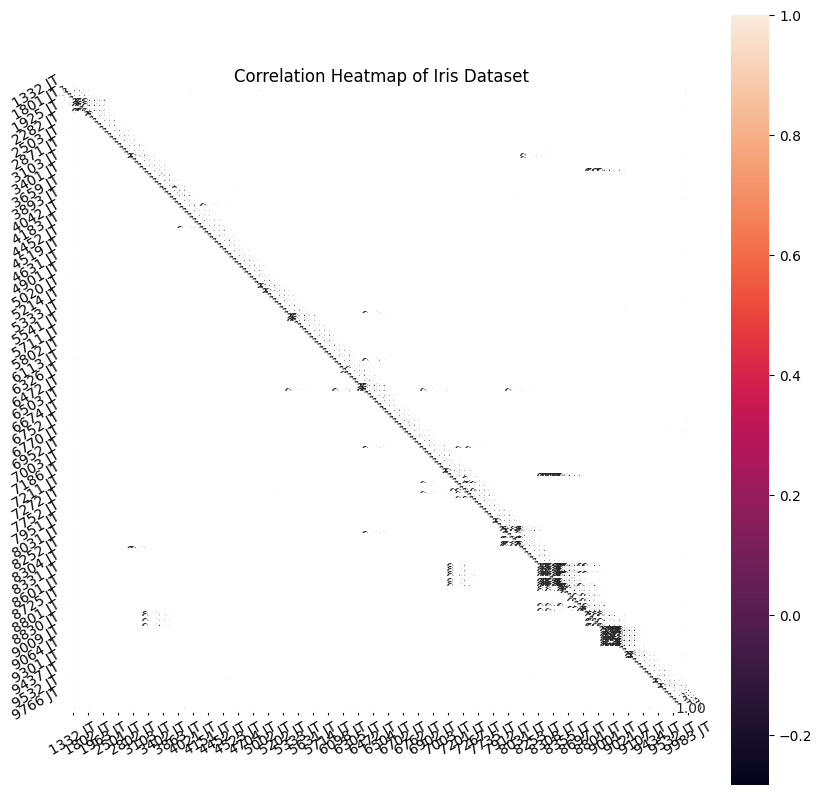

In [43]:
import seaborn as sns
corr_matrix = df_all[tickers].pct_change().corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Heatmap of Iris Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

In [44]:
corr_matrix

,1332 JT,1333 JT,1334 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1808 JT,1812 JT,...,9503 JT,9531 JT,9532 JT,9602 JT,9613 JT,9681 JT,9735 JT,9766 JT,9983 JT,9984 JT
1332 JT,1.000000,0.445439,0.227936,0.280675,0.369227,0.363515,0.379654,0.391443,0.378188,0.406045,...,0.275649,0.323533,0.357757,0.355190,0.384026,0.280405,0.421253,0.303651,0.284464,0.259416
1333 JT,0.445439,1.000000,NaN,0.226925,0.318620,0.334100,0.331953,0.347096,0.328714,0.321191,...,0.342752,0.338967,0.384954,0.356376,0.348285,0.245612,0.385539,0.338405,0.219091,0.236664
1334 JT,0.227936,NaN,1.000000,0.115921,0.206927,0.238592,0.219310,0.212735,NaN,0.210724,...,0.196526,0.162817,0.207349,0.187449,0.205039,0.311317,0.241849,0.176211,0.231048,0.170707
1605 JT,0.280675,0.226925,0.115921,1.000000,0.348256,0.345231,0.370028,0.373090,0.415035,0.369829,...,0.289797,0.295158,0.332658,0.283939,0.380358,0.243482,0.398387,0.300446,0.335514,0.351630
1721 JT,0.369227,0.318620,0.206927,0.348256,1.000000,0.527966,0.520566,0.528013,0.459306,0.531350,...,0.313771,0.394732,0.432572,0.384036,0.492079,0.379142,0.562920,0.393378,0.424992,0.335169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681 JT,0.280405,0.245612,0.311317,0.243482,0.379142,0.349052,0.372372,0.376943,0.329958,0.354293,...,0.327025,0.340482,0.358325,0.427733,0.377790,1.000000,0.463832,0.332049,0.368991,0.261995
9735 JT,0.421253,0.385539,0.241849,0.398387,0.562920,0.479194,0.502052,0.533105,0.487674,0.497225,...,0.390540,0.521151,0.533755,0.532668,0.580030,0.463832,1.000000,0.466000,0.527014,0.393517
9766 JT,0.303651,0.338405,0.176211,0.300446,0.393378,0.399872,0.371644,0.403478,0.327524,0.398866,...,0.270523,0.287182,0.319345,0.350141,0.467975,0.332049,0.466000,1.000000,0.379914,0.339864
9983 JT,0.284464,0.219091,0.231048,0.335514,0.424992,0.333737,0.356150,0.379471,0.361688,0.337966,...,0.283222,0.313875,0.320715,0.363734,0.499042,0.368991,0.527014,0.379914,1.000000,0.399739


If we check the correlation between '1332 JT' and other stocks, we can find that it has significant correlation with other stocks, it is possible that there stocks with strong correlation are from the same industry as '1332 JT'. They can be used to generate signals of trading '1332 JT'.

In [237]:
corr_matrix['1332 JT'].abs().sort_values(ascending=False)

1332 JT    1.000000
2002 JT    0.481153
4631 JT    0.462539
2801 JT    0.451131
1333 JT    0.445439
             ...   
9434 JT    0.145932
4751 JT    0.143723
6753 JT    0.133388
3893 JT    0.016504
3659 JT    0.011849
Name: 1332 JT, Length: 248, dtype: float64

## Let us start with one-single stock 

The basic idea of alpha is to predict the future movement of the stock price, and then we incorporate this alpha into our strategy:

If the alpha value is positive, which means the stock price will increase on the next day, then we hold the stock. 

If the alpha value is negative, we short the stock instead.

Here we focus on stock '1332 JT'.

In [372]:
ticker = df.ticker.unique()[0]
data = df[df.ticker==ticker].set_index('Date')[['last','volume']].dropna()
data.columns = ['Close','Volume']
data["Return_t"] = data["Close"].pct_change()
data["Return_t-1"] = data["Return_t"].shift(1)
data["Return_t-2"] = data["Return_t"].shift(2)
data["Target"] = (data["Close"].pct_change().shift(-1)>0)*1#data["Close"].shift(-1)#(data["Close"].pct_change().shift(-1)>0)*1
data["Vol_change"] = data["Volume"].diff()
data.dropna(inplace=True)

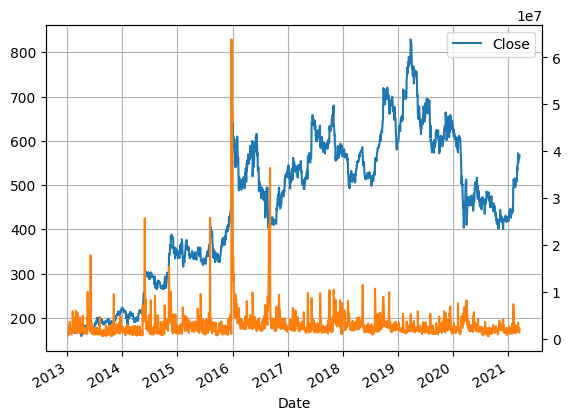

In [373]:
fig, ax = plt.subplots()
data.Close.plot(ax=ax,label='Close')
data.Volume.plot(ax=ax,label='Volume', secondary_y=True)
ax.grid()
ax.legend()

**Observation** We can see from the plot that most of the time, the spike of stock price is combine with the spike of the volume, and then followed by drop. Hence, the volume can be a very important information to predict price movement.


An statistical evidence is that hte Volume has 0.10 correlation with Close price and 0.18 with Return. The correlation is not very strong but still considerable.

Now let us have a check on the moving average price.

In [374]:
data['SMA'] = data['Close'].rolling(window=20).mean()
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()
short_ema = data['Close'].ewm(span=12, adjust=False).mean()
long_ema = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = short_ema - long_ema
data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

**Observation:** Another observation is that when the short-term exponentially wighted moving average(EMA) is larger (or short) than long term EMA, it usually follows a short period of up (down) trend of price. This observation can be used to design our 
trend follow strategy.

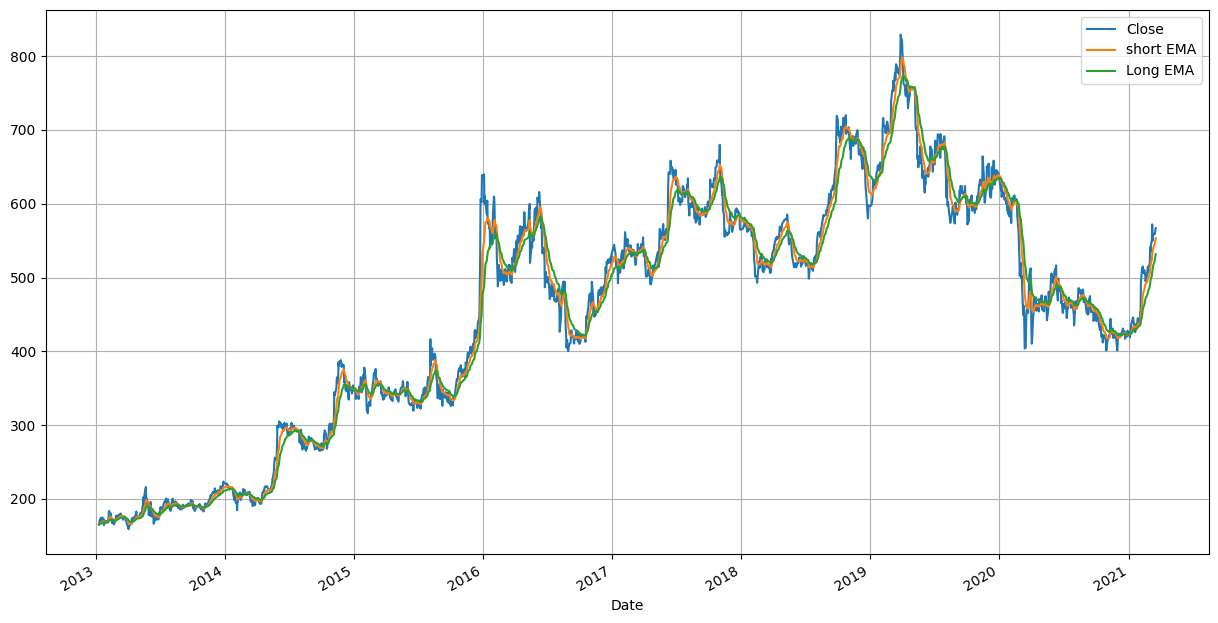

In [375]:
fig, ax = plt.subplots(figsize = (15,8))
data.Close.plot(ax=ax,label='Close')
short_ema.plot(ax=ax,label='short EMA')
long_ema.plot(ax=ax,label='Long EMA')
ax.grid()
ax.legend()

In [376]:
from statsmodels.graphics.tsaplots import plot_acf

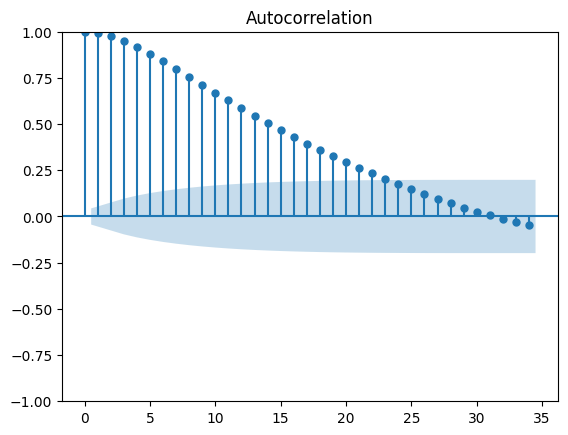

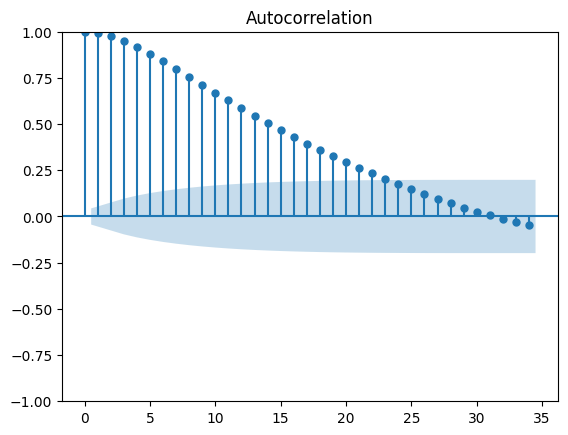

In [377]:
plot_acf(data['MACD'])

### Feature Selection 
Given those candidate features, we now need to select several most informative features to use in our predictive model.

In [378]:
from xgboost import XGBClassifier,cv
from sklearn.feature_selection import f_classif
import xgboost as xgb

Usually we can select the features by checking the correlation, however a more robust way is to select features based on some statistical test like ANOVA test.

In [379]:
data.corr()

,Close,Volume,Return_t,Return_t-1,Return_t-2,Target,Vol_change,SMA,EMA,MACD,Signal Line
Close,1.000000,0.103020,0.007026,0.005629,0.008486,-0.020117,0.000608,0.987370,0.991052,0.118114,0.121390
Volume,0.103020,1.000000,0.182619,0.143023,0.094485,-0.008672,0.478992,0.061078,0.068312,0.187845,0.149093
Return_t,0.007026,0.182619,1.000000,-0.045044,0.036911,-0.054389,0.206195,-0.048010,-0.046026,0.059213,0.004704
Return_t-1,0.005629,0.143023,-0.045044,1.000000,-0.045040,0.002805,-0.041353,-0.046159,-0.041104,0.109526,0.027078
Return_t-2,0.008486,0.094485,0.036911,-0.045040,1.000000,-0.020026,-0.050838,-0.043492,-0.035821,0.150125,0.053557
Target,-0.020117,-0.008672,-0.054389,0.002805,-0.020026,1.000000,-0.025242,-0.013954,-0.016570,-0.019857,-0.021929
Vol_change,0.000608,0.478992,0.206195,-0.041353,-0.050838,-0.025242,1.000000,-0.002084,-0.003815,-0.015701,-0.014347
SMA,0.987370,0.061078,-0.048010,-0.046159,-0.043492,-0.013954,-0.002084,1.000000,0.999359,0.001972,0.040627
EMA,0.991052,0.068312,-0.046026,-0.041104,-0.035821,-0.016570,-0.003815,0.999359,1.000000,0.013831,0.042778
MACD,0.118114,0.187845,0.059213,0.109526,0.150125,-0.019857,-0.015701,0.001972,0.013831,1.000000,0.951930


function f_classif can be used to implement univariate ANOVA test for classification problem,.

In [383]:
data= data.dropna()
features = data[['Close','Volume','Return_t','Return_t-1','Return_t-2','Vol_change','SMA','EMA','MACD','Signal Line']]
target = data['Target']
_,p = f_classif(features,target)
p

array([0.43649099, 0.70846754, 0.01447919, 0.74431083, 0.35942519,
       0.23948717, 0.53458061, 0.53521693, 0.38114428, 0.32998976])

Usually we only select features with $p$-value less than 5. However, in this case, we have almost all values >5%.  It is possible that the linear dependency between features and target is too weak. Just in case feature and target present nonlinear dependancy, we use tree-based model, that is Random Forest which is capable of modeling non-linear relation and allievate overfitting problem to some extend (due to its bagging nature).

In [404]:
X = data[['Close','Volume','Return_t','Return_t-1','Return_t-2','Vol_change','SMA','EMA','MACD','Signal Line']]
y = data["Target"] 
# Train test split:
# Here we use the last 20% dates as the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),#used to deal with nan value
    ('classifier', RandomForestClassifier(n_estimators=100,max_depth=6,random_state=0))
])
#fit random forest
pipeline.fit(X_train, y_train)

# Evaluate the performance on training set
y_pred_train = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
# Evaluate the performance on test set
y_pred_test = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.7843631778058008
Test Accuracy: 0.5340050377833753


In [412]:
# Construct the strategy
data["Predicted_Return"] = np.sign(1/2-pipeline.predict(X)) # since binary precition is 0,1, we convert it into -1,1
data["Signal"] = data["Predicted_Return"]
data.loc[data["Signal"] > 0, "Position"] = 1  
data.loc[data["Signal"] < 0, "Position"] = -1  

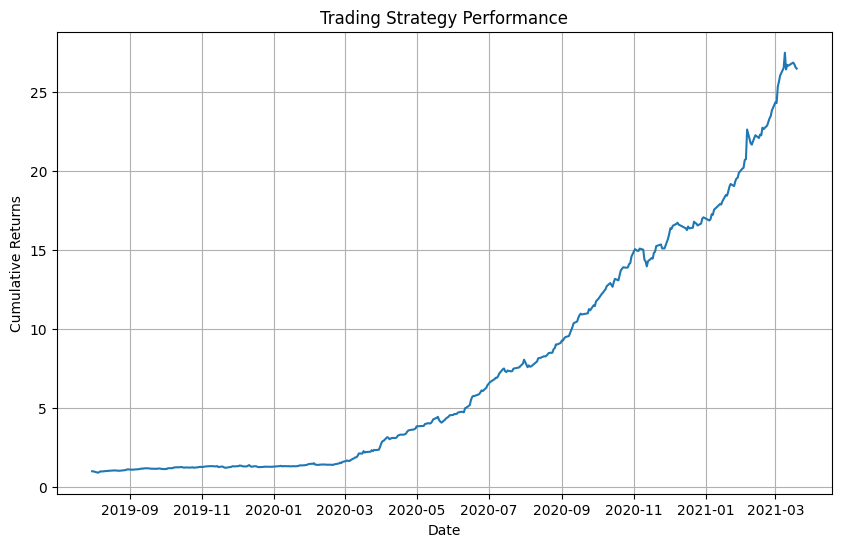

In [413]:
#Backtesting
test_index= int(0.8*len(data))
data["Strategy_Return"] = data["Position"] * data["Return_t"]
cumulative_returns = (data["Strategy_Return"] + 1).cumprod()
cumulative_returns_test = (data["Strategy_Return"].values[test_index:] + 1).cumprod()
plt.figure(figsize=(10, 6))
#plt.plot(data.index, cumulative_returns)
plt.plot(data.index[test_index:], cumulative_returns_test )
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Strategy Performance")
plt.grid(True)
plt.show()

The performance of the XGB strategy is just fine, but apparently it has larget drawdown. Although the cum return ever reached 1.85, it quickly dropped down at the end of 2020. The main reason of this unsatisfactory results is the poor accuracy of the XGBClassifier.

### Compare with trend follow strategy 

Let us use the mean reversion stratgy as a comparison (benchmark), in the plot below, we can see that mean reversion strategy has much more stable  performance. The return reachs around 60% which is worse than that of RF strategy

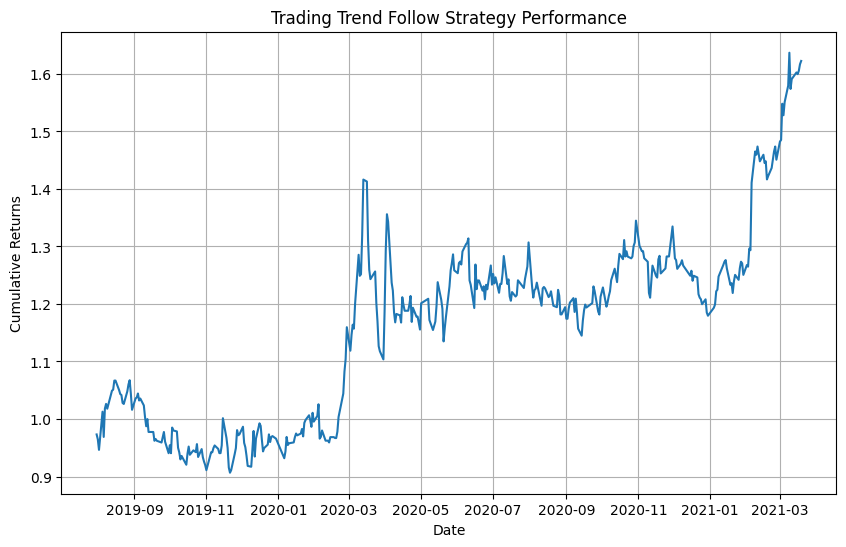

In [414]:
#Backtesting
test_index= int(0.8*len(data))
data["MRStrategy_Return"] = np.sign(data["MACD"]) * data["Return_t"]
cumulative_returns = (data["MRStrategy_Return"] + 1).cumprod()
cumulative_returns_test = (data["MRStrategy_Return"].values[test_index:] + 1).cumprod()
plt.figure(figsize=(10, 6))
plt.plot(data.index[test_index:], cumulative_returns_test )
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Trend Follow Strategy Performance")
plt.grid(True)
plt.show()

# Further improvement 

* It is possible to improve the performance of classifier by using more information. For example, we previously notice the strong correlation between each stock, we can also exrtrac information from other stocks to predict the target stock return.
* The turnover of ML strategy can be high, we can improve the strategy to design some hodling period.